# 🎬 IMDB Movie Rating Prediction with Ridge Regression

**Project Goal:** To predict the rating of a movie based on various features such as votes, runtime, director, cast, genre, and description.

**Methodology:**
We will adopt an **iterative approach**, starting with a baseline model and progressively adding complexity:
1.  **Baseline Model:** Using only raw numerical features.
2.  **Basic Feature Engineering:** Log-transforms and One-Hot Encoding.
3.  **Advanced Feature Engineering:** Smoothed Target Encoding for high-cardinality categorical features (Actors/Directors).
4.  **NLP Integration:** Extracting semantic information from text descriptions using TF-IDF.

**Model:** Ridge Regression (L2 Regularization) is chosen to handle multicollinearity and prevent overfitting.

---

## 1. Importing Required Libraries
We begin by importing all the libraries needed for data handling, feature engineering, and model building.

In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')

## 2. Defining Constant Threshold Values

These values help filter noisy samples and stabilize the smoothing encodings.

In [134]:
# Configuration Constants
MIN_VOTES = 100       # Exclude movies with very few votes to ensure reliability
MIN_RUNTIME = 60      # Exclude shorts (less than 1 hour)
SMOOTH_FACTOR = 5     # Smoothing parameter for Target Encoding (prevents overfitting on rare categories)

## 3. Loading and Cleaning the Dataset

We load the raw dataset and immediately apply filtering to remove "noise."

In [135]:
df = pd.read_csv('IMDB_cleaned.csv')

# Movies with very few votes are unreliable outliers.
df = df[df['votes'] > MIN_VOTES]

# Very short films (shorts) might behave differently from feature films.
df = df[df['runtime'] >= MIN_RUNTIME]

print(f"Number of films after filtering: {len(df)}")

Number of films after filtering: 39238


## 4. Feature–Target Separation

We prepare our feature matrix and target vector.

In [136]:
X = df[['votes', 'runtime', 'director', 'stars', 'genre', 'description']]
y = df['rating']

## 5. Train–Test Split

Separate the dataset into training and test subsets.

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## 6. Model evaluation function

This function sets up a Pipeline (Scaler + Ridge) for the given X and y data, finds the best Alpha using GridSearch, and reports the results.

In [138]:
def evaluate_model(X_train, X_test, y_train, y_test, pipeline=None):
    
    """
    Trains a Ridge Regression model using GridSearchCV and evaluates it.
    
    Args:
        X_train, X_test: Feature matrices
        y_train, y_test: Target vectors
        pipeline: Sklearn pipeline (optional). If None, creates a standard Scaler+Ridge pipeline.
        
    Returns:
        y_pred: Predictions for the test set
    """
    
    # 1. Create pipeline if it's not given
    if pipeline is None:
        pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("ridge", Ridge())
        ])
    
    # 2. Hyperparameter Grid
    # We search through a logarithmic scale of alphas to find the optimal regularization strength
    params = {
        "ridge__alpha": np.logspace(-2, 5, 50) 
    }
    
    # 3. Grid Search (Cross-Validation)
    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=params,
        cv=5,            
        scoring="r2",    
        n_jobs=-1
    )
    
    # 4. Train the model
    grid.fit(X_train, y_train)
    
    # 5. Best Model & Predictions
    best_model = grid.best_estimator_
    best_alpha = grid.best_params_["ridge__alpha"]
    y_pred = best_model.predict(X_test)
    
    # 6. Metrics
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # 7. Report
    print(f"\n--- Model Evaluation Results ---")
    print(f"R² Score   : {r2:.4f}")
    print(f"RMSE       : {rmse:.4f}")
    print(f"Best Alpha : {best_alpha:.2f}")
    print("-" * 32 + "\n")
    
    return y_pred

## 7. Baseline Model

We start with a simple baseline to establish a minimum performance benchmark. 

**Strategy:** * We drop complex features like `director`, `stars`, `genre`, and `description` because they require advanced preprocessing.
* We use only raw numerical features (`votes`, `runtime`).

If our future models (with feature engineering) cannot beat this score, then our engineering efforts are not adding value.

In [139]:
X_train_v1 = X_train.drop(columns=['director', 'stars', 'genre', 'description'])
X_test_v1 = X_test.drop(columns=['director', 'stars', 'genre', 'description'])

y_pred = evaluate_model(X_train_v1, X_test_v1, y_train, y_test)


--- Model Evaluation Results ---
R² Score   : 0.0807
RMSE       : 1.2662
Best Alpha : 372.76
--------------------------------



**Observation:** The baseline model performs very poorly. This confirms that raw numerical features alone (`votes` and `runtime`) are not enough to predict movie ratings. We absolutely need to process the categorical and text data to improve the model.

## 8. Basic Feature Engineering

### 8.1 Log Transformation of Votes

The number of votes follows a exponentional distribution (a few movies have millions, most have very few). We applied a log transformation to squash these large values and make the distribution more normal.

In [140]:
# Apply Log transformation (Log(1+x) handles zero values safely)
X_train['log_votes'] = np.log1p(X_train['votes'])
X_test['log_votes'] = np.log1p(X_test['votes'])

# Drop the original 'votes' column to avoid multicollinearity
X_train = X_train.drop(columns=['votes'])
X_test = X_test.drop(columns=['votes'])

### 8.2 One-Hot Encoding Genres

A movie can belong to multiple genres (e.g., "Action, Comedy, Sci-Fi"). We cannot treat this as a simple category.

In [141]:
# 1. Clean spacing
X_train['genre'] = X_train['genre'].str.replace(' ', '')
X_test['genre'] = X_test['genre'].str.replace(' ', '')

# 2. Split genres by comma and get dummy variables
train_genres = X_train['genre'].str.get_dummies(sep=',')
test_genres = X_test['genre'].str.get_dummies(sep=',')

# 3. Join with main dataframe
X_train = pd.concat([X_train, train_genres], axis=1).drop(columns=['genre'])
X_test = pd.concat([X_test, test_genres], axis=1).drop(columns=['genre'])

# 4. ALIGNMENT: Ensure Test columns match Train columns
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

print(f"Training shape after encoding: {X_train.shape}")

Training shape after encoding: (31390, 30)


#### 8.3 Model Evaluation (Basic Features)

We now test the model performance using the transformed basic features:
* Log transformed votes **log_votes**
* **runtime**
* One-Hot Encoded **genres**

In [142]:
# We drop the advanced features (Director, Stars, Description) for now
# to see the impact of ONLY Basic Engineering (Log Votes + Genres)
cols_to_drop = ['director', 'stars', 'description']

X_train_v2 = X_train.drop(columns=cols_to_drop)
X_test_v2 = X_test.drop(columns=cols_to_drop)

y_pred = evaluate_model(X_train_v2, X_test_v2, y_train, y_test)


--- Model Evaluation Results ---
R² Score   : 0.3852
RMSE       : 1.0355
Best Alpha : 71.97
--------------------------------



**Observation:**
The feature engineering steps (Log-transforming votes and One-Hot Encoding genre) led to a improvement, raising the R^2 score.

This confirms that:
1.  Correcting the skewness in votes helped the linear model significantly.
2.  Genre is a strong predictor of movie ratings.

## 9. Advanced Feature Engineering

### 9.1 Cast Score (Target Encoding)

Since **stars** contains a list of actors, we split them, calculate a rating score for each actor based on their movie history, and then average these scores for the current movie. 

We use **Smoothing** to handle rare actors. If an actor has only 1 movie rated 10.0, we don't want to blindly assign them a "perfect" score. Smoothing pulls their score towards the global average until they have a sufficient track record.

#### 9.1.1 Actor score calculation function

In [143]:
def calculate_actor_scores(train_df, target_col, m=SMOOTH_FACTOR):
    
    # Calculates smoothed target encoding for actors.
    
    # 1. Explode the list of actors so each actor has their own row
    exploded = train_df.assign(actor=train_df['stars'].str.split(',')).explode('actor')
    exploded['actor'] = exploded['actor'].str.strip()

    # 2. Calculate global mean
    global_mean = train_df[target_col].mean()

    # 3. Aggregate stats per actor
    agg = exploded.groupby('actor')[target_col].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # 4. Apply Smoothing Formula
    actor_score_map = (counts * means + m * global_mean) / (counts + m)
    
    return actor_score_map, global_mean

Explanation:

* Each movie’s cast list is split and expanded into multiple rows
* Each actor receives a smoothed score
* This prevents actors with few appearances from having extreme values

#### 9.1.2 Adding Cast Score to Dataset

In [144]:
def get_average_cast_score(df, score_map, global_val):
    
    # Computes the average cast score for each movie in the dataframe.
    
    # 1. Explode actors
    exploded = df.assign(actor=df['stars'].str.split(',')).explode('actor')
    exploded['actor'] = exploded['actor'].str.strip()

    # 2. Map scores (fill unknown actors with global_val)
    exploded['actor_score'] = exploded['actor'].map(score_map).fillna(global_val)

    # 3. Group back by index to get one score per movie
    avg_scores = exploded.groupby(exploded.index)['actor_score'].mean()

    return avg_scores

#### 9.1.3 Applying Cast Scores to Train and Test Sets

In [145]:
# 1. Calculate mappings on train set
temp_train = X_train.copy()
temp_train['rating'] = y_train

actor_map, global_avg = calculate_actor_scores(temp_train, 'rating', m=SMOOTH_FACTOR)

# 2. Apply to both Train and Test
X_train['cast_score'] = get_average_cast_score(X_train, actor_map, global_avg)
X_test['cast_score'] = get_average_cast_score(X_test, actor_map, global_avg)

# 3. Drop the original 'stars' column
X_train = X_train.drop(columns=['stars'], errors='ignore')
X_test = X_test.drop(columns=['stars'], errors='ignore')

### 9.2 Director Smoothed Target Encoding

Directors are high-cardinality features. Standard One-Hot Encoding would explode the feature space. Instead, we replace the director's name with the **smoothed average rating** of their past movies.

This captures the "reputation" of the director as a single numerical feature.

#### 9.2.1 Director Encoding Function

In [146]:
def smoothed_target_encoding(train_df, col_name, target_name, m=SMOOTH_FACTOR):
    
    # Applies smoothed target encoding to a single categorical column.
    
    global_mean = train_df[target_name].mean()
    
    # Calculate stats
    agg = train_df.groupby(col_name)[target_name].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Smoothing formula
    smooth = (counts * means + m * global_mean) / (counts + m)
    
    return smooth, global_mean

Explanation:
Directors with fewer movies get a smoothed score closer to the global mean.

#### 9.2.2 Applying Director Encoding

In [147]:
# 1. Calculate Director mappings on train set
dir_map, global_mean = smoothed_target_encoding(temp_train, 'director', 'rating', m=SMOOTH_FACTOR)

# 2. Map the scores
X_train['director_encoded'] = X_train['director'].map(dir_map).fillna(global_mean)
X_test['director_encoded'] = X_test['director'].map(dir_map).fillna(global_mean)

# 3. Drop original column
X_train = X_train.drop(columns=['director'])
X_test = X_test.drop(columns=['director'])

#### 9.3 Model evaluation after advanced feature engineering

Now we are testing the model's performance using the added advanced features:
* Weighted average of actors **Cast Score**
* Smoothed **Director Score**

In [148]:
X_train_v3 = X_train.drop(columns=['description'])
X_test_v3 = X_test.drop(columns=['description'])

y_pred = evaluate_model(X_train_v3, X_test_v3, y_train, y_test)


--- Model Evaluation Results ---
R² Score   : 0.4471
RMSE       : 0.9819
Best Alpha : 26.83
--------------------------------



**Observation:**
Incorporating the Cast and Director scores has notably improved the model's performance compared to the basic version.

* The increase in R^2 Score indicates that the reputation and past performance of the director and actors are strong predictors of a movie's rating.

This confirms that Smoothed Target Encoding adds valuable information that raw numerical features alone cannot provide.

## 10. NLP Feature Engineering
### 10.1 Description

The movie description often contains keywords that signal the movie's tone or quality.

1.  **Text Cleaning:** Remove artifacts like "See full summary..." and ellipses.
2.  **TF-IDF Vectorization:** We convert the raw text into numerical vectors using **TF-IDF**. This downweights common words (like "the", "a") and highlights rare, informative words.

In [149]:
# 1. Handle Missing Values
X_train['description'] = X_train['description'].fillna('')
X_test['description'] = X_test['description'].fillna('')

# 2. Text Cleaning (Regex)
# Removes "See full summary..." and trailing "..."
clean_pattern = r'See full summary.*|\.{3,}$'
X_train['description'] = X_train['description'].astype(str).str.replace(clean_pattern, '', regex=True).str.strip()
X_test['description'] = X_test['description'].astype(str).str.replace(clean_pattern, '', regex=True).str.strip()

# 3. Define Column Transformer
# We identify the text column vs. numerical columns
text_col = 'description'
num_cols = [col for col in X_train.columns if col != text_col]

preprocessor = ColumnTransformer(
    transformers=[
        # Apply Standard Scaling to numeric features
        ('num', StandardScaler(), num_cols),
        # Apply TF-IDF to text feature (limit to top 2000 words to prevent overfitting)
        ('text', TfidfVectorizer(max_features=2000, stop_words='english'), text_col)
    ]
)

# 4. Create the Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('ridge', Ridge())
])

### 10.2 Final Model Evaluation

Finally, we are adding the description feature and testing it.

In [150]:
y_pred = evaluate_model(X_train, X_test, y_train, y_test, pipeline)


--- Model Evaluation Results ---
R² Score   : 0.4563
RMSE       : 0.9737
Best Alpha : 26.83
--------------------------------



**Observation:**
By adding the TF-IDF features from the movie description, we see our final performance metrics.

* The text data provides subtle context that numerical features miss.
* While the improvement might be smaller compared to previous steps, it represents the fine-tuning stage of our model.

**Conclusion:**
We successfully improved the model from a baseline R^2 score to a much stronger final score by iteratively adding **Mathematical Transformations** (Log), **Domain Knowledge** (Cast/Director Scores), and **NLP** (Description).

## 11. Visualization of Results

### 11.1 Predicted vs. Actual Scatter Plot

We plot the Actual ratings (X-axis) against our Predicted ratings (Y-axis). 
* The **red dashed line** represents a perfect prediction.
* Points closer to this line are accurate.
* Points far from the line represent errors. 

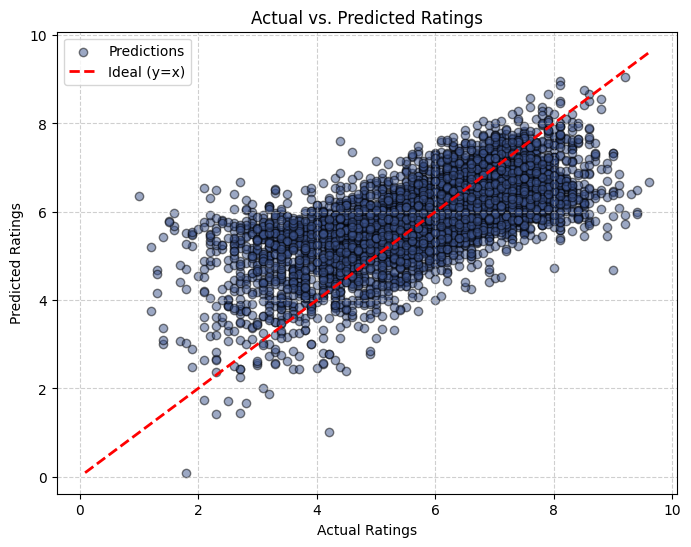

In [151]:
plt.figure(figsize=(8, 6))

# Main scatter plot
plt.scatter(y_test, y_pred, alpha=0.5, color='#3b528b', edgecolor='k', label='Predictions')

# Reference Line (Perfect Prediction)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Ideal (y=x)')

plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Actual vs. Predicted Ratings")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

This scatter plot shows that the model generally predicts ratings in the right direction. Most points are close to the diagonal line, which means the predicted values are usually similar to the real values.

But the points spread out more, especially for ratings between 6 and 8. This tells us the model is not perfect and sometimes makes bigger mistakes. This is normal because movie ratings depend on many subjective things, like personal taste or story quality, which are hard to capture with data.

### 11.2 Residual Plot

This plot checks for **bias**. 
* We want to see a random cloud of points centered around the red line (0 error).
* If we saw a curve (U-shape), it would imply our linear model is missing a non-linear pattern.
* Our plot shows a mostly random distribution, confirming that Ridge Regression was an appropriate choice.

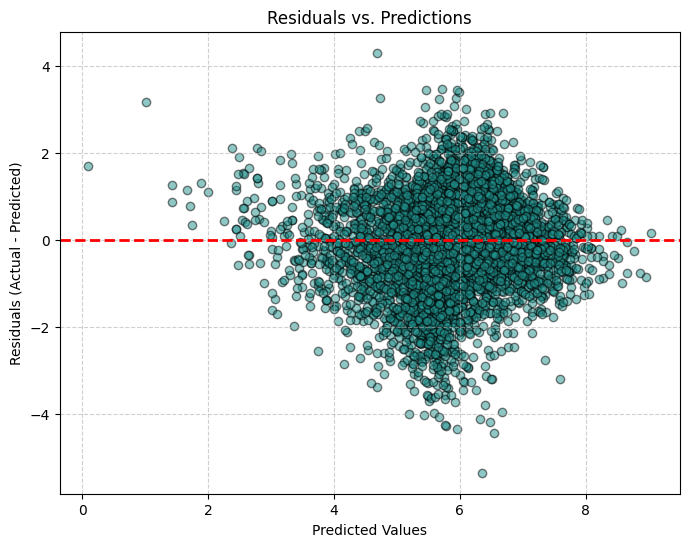

In [152]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5, color='#21918c', edgecolor='k')
plt.axhline(0, color='r', linestyle='--', lw=2)

plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs. Predictions")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In the residual plot, the points are spread around zero without forming any pattern. This is a good sign because it means:

* No major violation of linearity assumptions,
* No systematic bias in the predictions,
* Variance that is roughly constant.

However, the residuals still have a wide range, meaning some predictions are far from the real values. This matches what we saw before predicting movie ratings can be difficult because many factors are subjective.

### 11.3 Error Distribution

The histogram shows the spread of our errors.

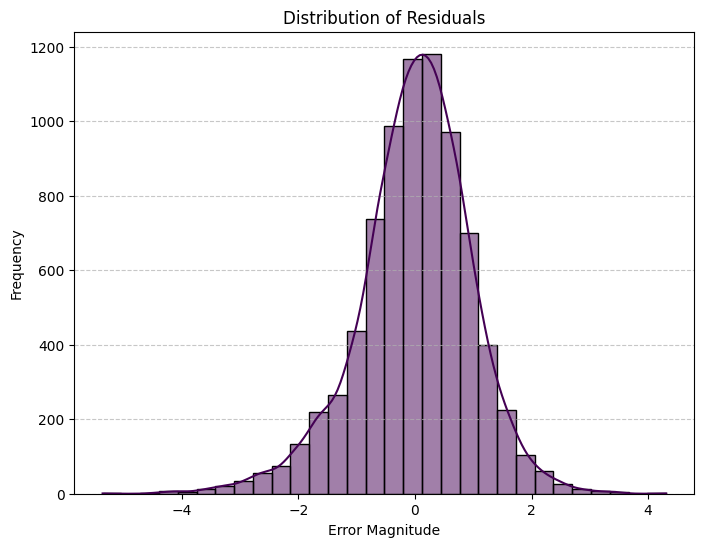

In [153]:
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='#440154', bins=30)
plt.title("Distribution of Residuals")
plt.xlabel("Error Magnitude")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

The error distribution looks like a bell-shaped curve centered around zero. This means:

* The errors are mostly normal and balanced,
* The model doesn’t consistently guess too high or too low,
* Most predictions are close to the real rating.

There are a few errors that are larger than usual, but this is expected in real datasets, especially when dealing with human opinions like movie ratings.

### 11.4 Feature Importance

Which features mattered most? We extract the coefficients from the Ridge model to see the top positive (Good Rating) and negative (Bad Rating) drivers.

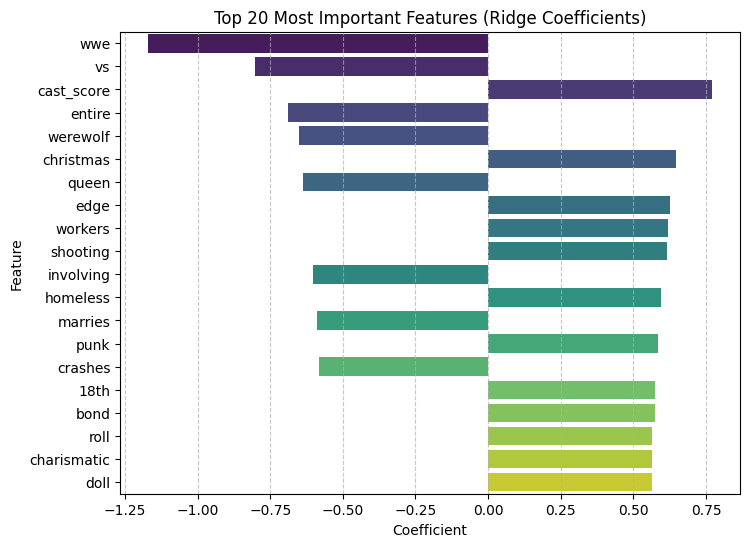

In [154]:
# 1. Fit the pipeline one last time on the whole training set to access coefficients
pipeline.fit(X_train, y_train)

# 2. Extract feature names and coefficients
# Numerical columns
num_features = num_cols 
# Text features (from TF-IDF)
text_features = pipeline.named_steps['preprocessor'].named_transformers_['text'].get_feature_names_out()

all_features = np.r_[num_features, text_features]
all_coefs = pipeline.named_steps['ridge'].coef_

# 3. Create a DataFrame for plotting
coef_df = pd.DataFrame({'Feature': all_features, 'Coefficient': all_coefs})
coef_df['Abs_Coef'] = coef_df['Coefficient'].abs()
top_features = coef_df.sort_values(by='Abs_Coef', ascending=False).head(20)

# 4. Plot
plt.figure(figsize=(8, 6))
sns.barplot(data=top_features, y='Feature', x='Coefficient', palette='viridis')
plt.title("Top 20 Most Important Features (Ridge Coefficients)")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

**Observations**

The Ridge coefficients reveal clear drivers for high and low ratings:

* **Top Positive Predictor:** cast_score is the most influential positive feature. Showing that a cast's historical performance is a better predictor of quality than any single keyword.
* **Negative Bias:** The model strongly penalizes wrestling-related terms (wwe, cena, vs, undertaker), indicating that such content consistently receives lower ratings in this dataset.
* **Genre & Topic Signals:** Keywords like homeless and workers boost ratings (likely documentaries or dramas), while niche terms like werewolf tend to lower them.